# Visualize how `OnlinePicker` works

This notebook provides visualizations for the `OnlinePicker` algorithm within Euclidean space, offering insights into the algorithm's operational mechanics. Subsequently, it employs generated fingerprints to demonstrate the algorithm's performance on a "chemical" space.

The parameters of the algorithm are:

- `n_points`: the quantity of points to be selected,
- `p`: the power of the repulsion term,
- `k_neighbors`: the number of neighbors factored into the repulsion calculation

We construct a subset $P$ of `n_points` of a large set $M$ iteratively optimizing the following objective function:

$$ \mathcal{L} (P) = \mathcal{L} (\mathbf p_1, \cdots, \mathbf p_{n \text{ points}}) = \sum_{\mathbf p, \mathbf p' \in P} \dfrac{1}{|| \mathbf p - \mathbf p' ||^p} \to \min_{P \subset M}. $$

The sum is approximated by a sum over the `k_neighbors` of each point $\mathbf p \in P$.

In [1]:
import itertools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from tqdm.auto import tqdm

from moll.metrics import euclidean, one_minus_tanimoto
from moll.pick import OnlinePicker
from moll.utils import dist_matrix

Suppress warnings for clarity:

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Euclidean Space

### A unit square

Initialize random bathes

In [3]:
batches = jax.random.uniform(jax.random.PRNGKey(0), (100, 100, 2))

Fit picker for different values of `n_points` and `k_neighbors`:

  0%|          | 0/15 [00:00<?, ?it/s]

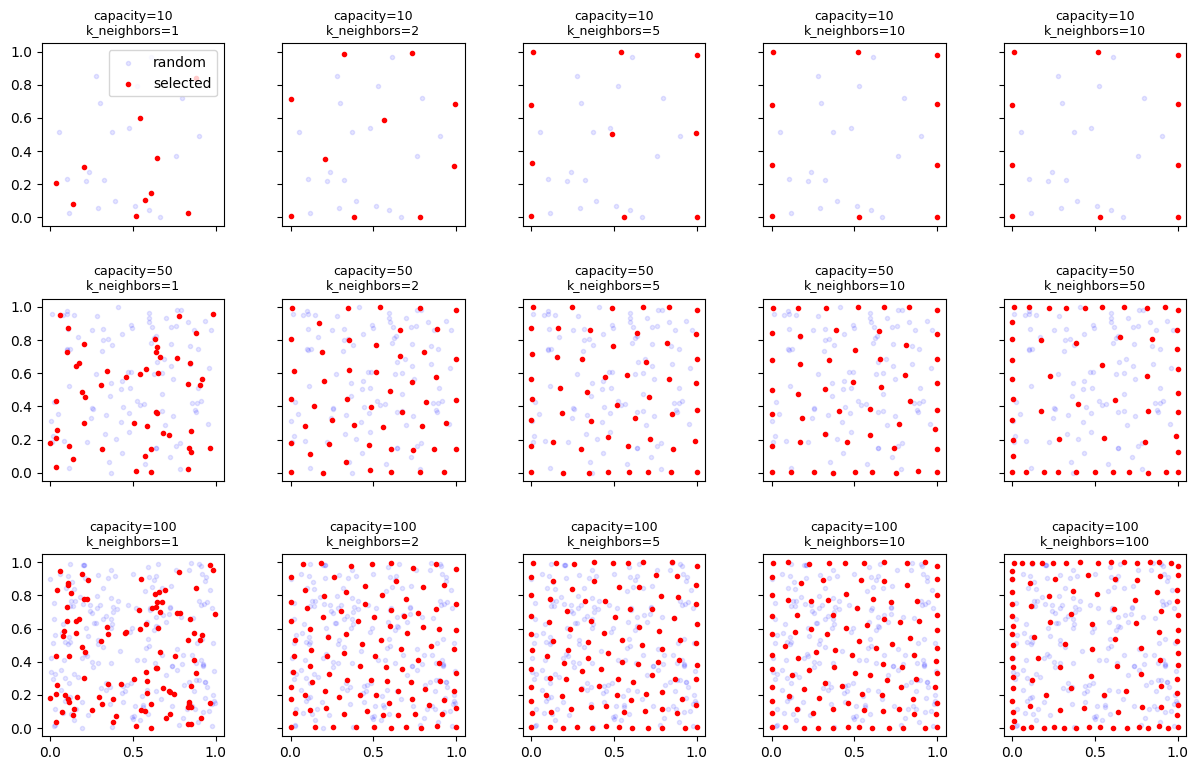

In [4]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)

capacity_list = [10, 50, 100]
k_neighbors_list = [1, 2, 5, 10, 100]

# flatten
for (i, capacity), (j, k_neighbors) in tqdm(
    itertools.product(enumerate(capacity_list), enumerate(k_neighbors_list)),
    total=len(capacity_list) * len(k_neighbors_list),
):
    k_neighbors = min(k_neighbors, capacity)
    picker = OnlinePicker(
        capacity=capacity,
        similarity_fn=euclidean,
        k_neighbors=k_neighbors,
    )

    # Iterate over the batches
    for batch in batches:
        picker.update(batch)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    # Get the random batch points
    point, y = jax.random.choice(
        jax.random.PRNGKey(0), batches.reshape(-1, 2), (capacity, 2)
    ).T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="random", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"capacity={capacity}\nk_neighbors={k_neighbors}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()

fig.subplots_adjust(hspace=0.4)
plt.show()

Fit picker for different values of `p` and `k_neighbors`:

  0%|          | 0/25 [00:00<?, ?it/s]

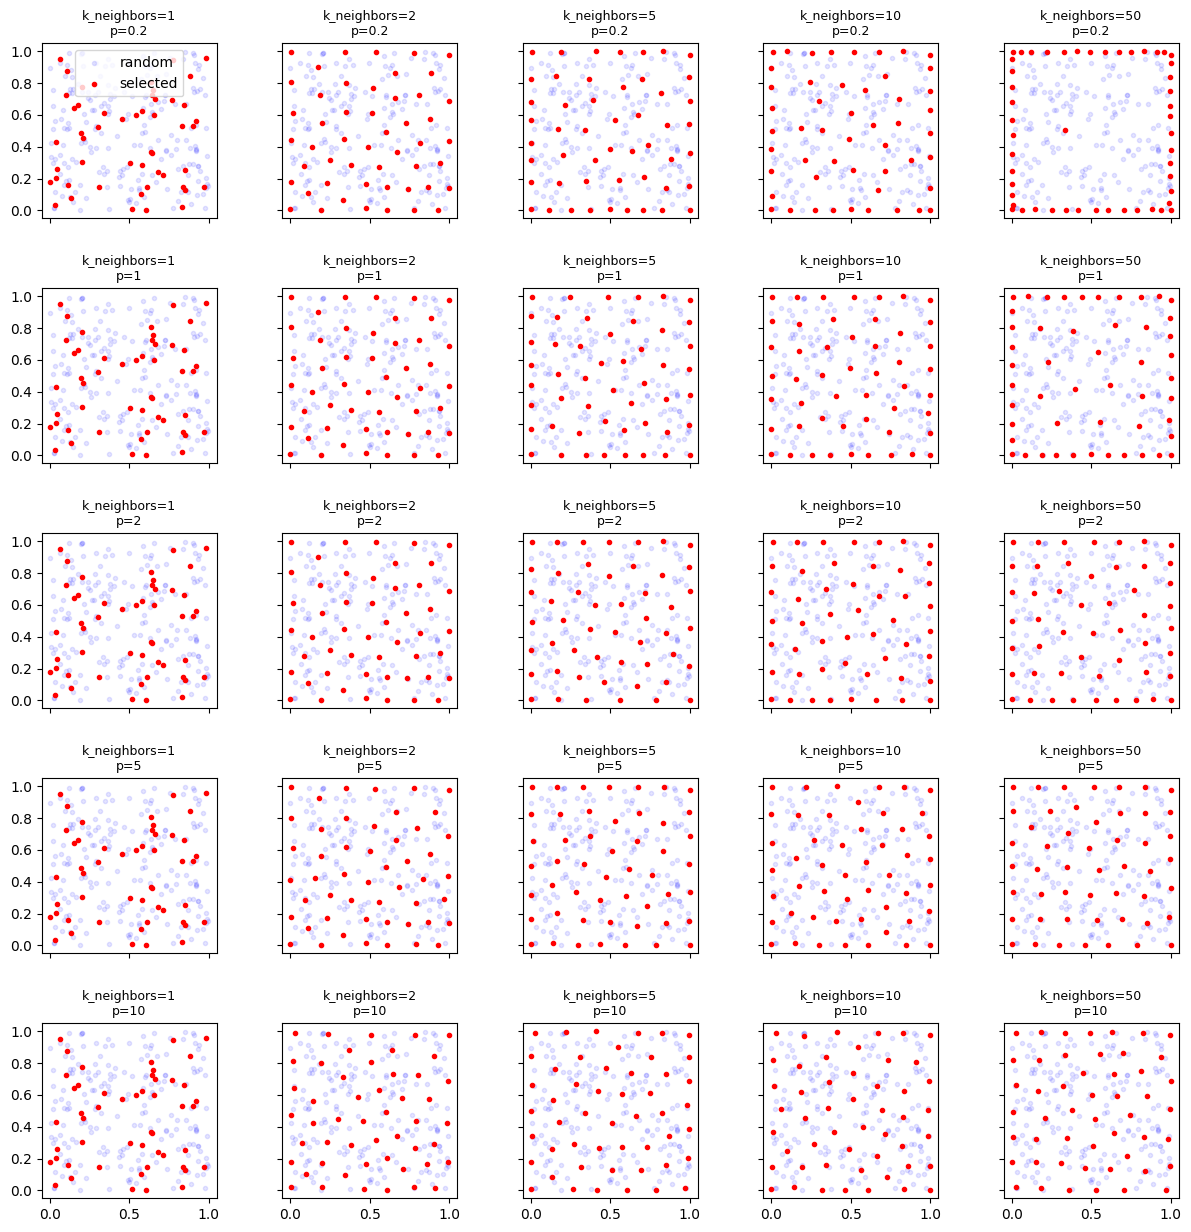

In [5]:
p_list = [0.2, 1, 2, 5, 10]
k_neighbors_list = [1, 2, 5, 10, 50]

fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# flatten
for (i, p), (j, k_neighbors) in tqdm(
    itertools.product(enumerate(p_list), enumerate(k_neighbors_list)),
    total=len(p_list) * len(k_neighbors_list),
):
    k_neighbors = min(k_neighbors, capacity)

    picker = OnlinePicker(
        capacity=50, similarity_fn=euclidean, k_neighbors=k_neighbors, p=p
    )

    # Iterate over the batches
    for batch in batches:
        picker.update(batch)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    # Get the random batch points
    point, y = jax.random.choice(
        jax.random.PRNGKey(0), batches.reshape(-1, 2), (capacity, 2)
    ).T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="random", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"k_neighbors={k_neighbors}\np={p}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()

fig.subplots_adjust(hspace=0.4)
plt.show()

### Blobs

Repeat the same procedure for spherical clusters:

In [6]:
points, _ = make_blobs(n_samples=10_000, random_state=21, centers=3)
np.random.seed(42)
np.random.shuffle(points)

  0%|          | 0/16 [00:00<?, ?it/s]

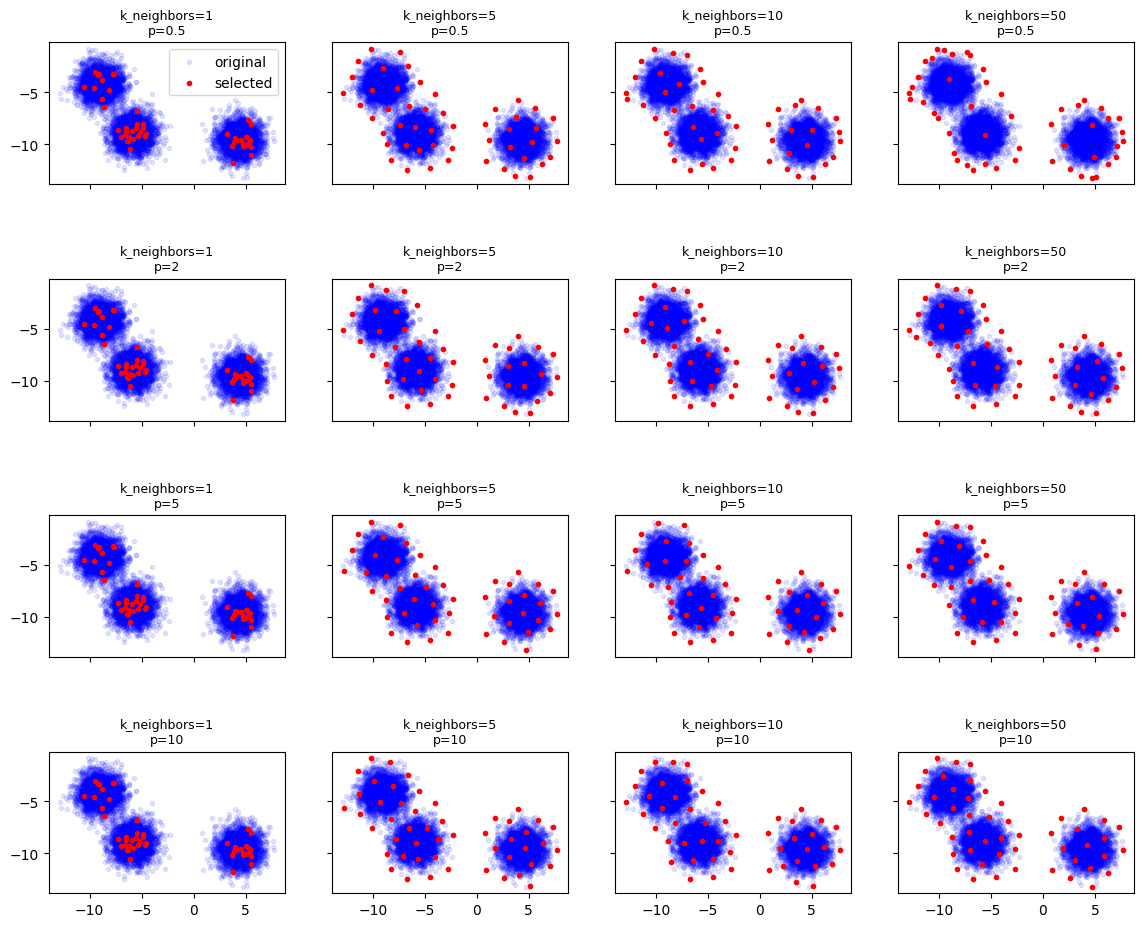

In [7]:
p_list = [0.5, 2, 5, 10]
k_neighbors_list = [1, 5, 10, 50]

fig, axes = plt.subplots(4, 4, figsize=(14, 12), sharex=True, sharey=True)

# flatten
for (i, p), (j, k_neighbors) in tqdm(
    itertools.product(enumerate(p_list), enumerate(k_neighbors_list)),
    total=len(p_list) * len(k_neighbors_list),
):
    picker = OnlinePicker(
        capacity=50, similarity_fn=euclidean, k_neighbors=k_neighbors, p=p
    )

    picker.update(points)

    # Get the selected points
    x_sel, y_sel = picker.points.T

    point, y = points.T

    # Plot the selected points
    axes[i, j].scatter(point, y, c="b", marker=".", label="original", alpha=0.1)
    axes[i, j].scatter(x_sel, y_sel, c="r", marker=".", label="selected")
    axes[i, j].set_title(f"k_neighbors={k_neighbors}\np={p}", fontsize=9)
    axes[i, j].set_aspect("equal")

    if i == 0 and j == 0:
        axes[i, j].legend()


fig.subplots_adjust(hspace=0.1)
plt.show()

## Chemical Space

Generate 10K fingerprints of length 100 using Bernoulli distribution:

In [8]:
fingerprints = jax.random.bernoulli(
    jax.random.PRNGKey(0), p=0.5, shape=(10_000, 100)
).astype(bool)

Define a function to calculate pairwise distances between fingerprints:

In [9]:
p_list = [0.1, 2, 50]
k_neighbors_list = [1, 10, 100, 300]

df = pd.DataFrame(columns=["p", "k_neighbors", "dist"])

# flatten
for p, k_neighbors in tqdm(
    itertools.product(p_list, k_neighbors_list),
    total=len(p_list) * len(k_neighbors_list),
):
    picker = OnlinePicker(
        capacity=300,
        similarity_fn=one_minus_tanimoto,
        k_neighbors=k_neighbors,
        p=p,
        threshold=0.55,
    )

    picker.update(fingerprints)

    # Get the selected points
    picked = picker.points

    # Compute distances
    dists = dist_matrix(picked, one_minus_tanimoto, condensed=True)

    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "p": p,
                    "k_neighbors": k_neighbors,
                    "dist": dists,
                }
            ),
        ]
    )

  0%|          | 0/12 [00:00<?, ?it/s]

Pairwise distances between the whole set of fingerprints:

In [10]:
fp_dists = dist_matrix(
    fingerprints[::100], one_minus_tanimoto, condensed=True
)  # take 1% as a random sample (points are random)

`OnlinePicker` prefers points from the right side of the distance distribution. The quality of solutions for Tanimoto distance does not depend heavily on the parameter `p`:

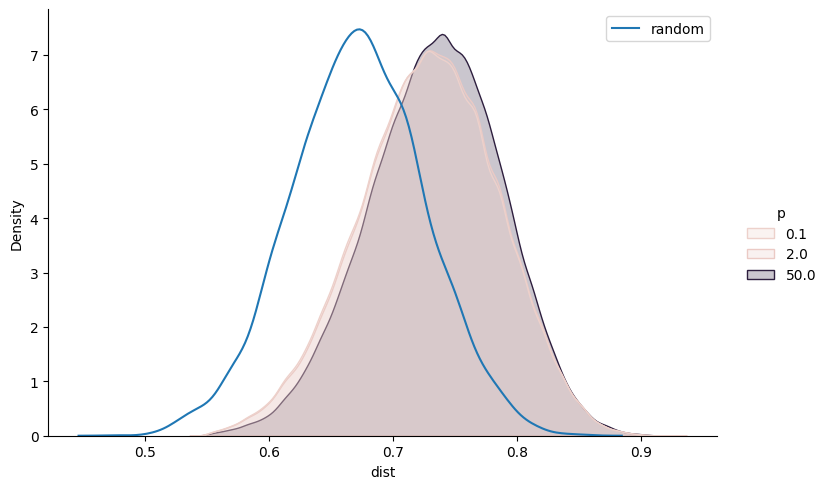

In [11]:
sns.displot(
    df,
    x="dist",
    hue="p",
    kind="kde",
    fill=True,
    common_norm=False,
    aspect=1.5,
)
sns.kdeplot(fp_dists, label="random")
plt.legend()
plt.show()

Number of neighbors taken into account for repulsion calculation has an effect on the quality:

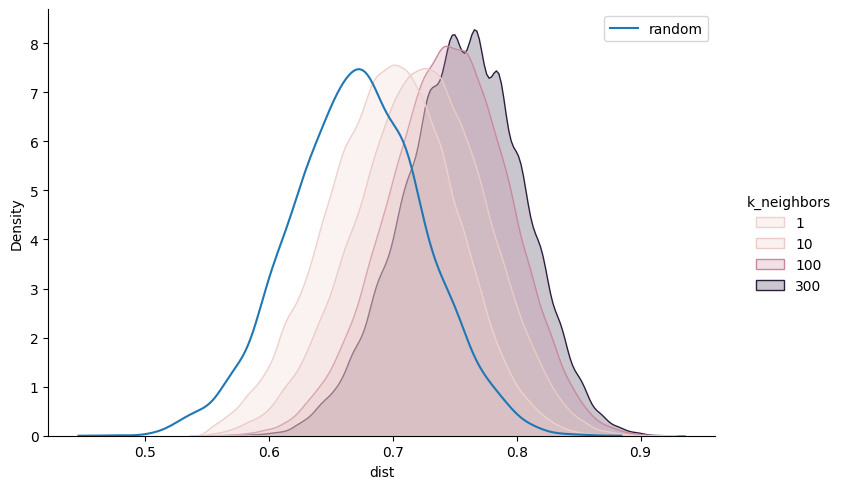

In [12]:
sns.displot(
    df,
    x="dist",
    hue="k_neighbors",
    kind="kde",
    fill=True,
    common_norm=False,
    aspect=1.5,
)
sns.kdeplot(fp_dists, label="random")
plt.legend()
plt.show()

N.B. Tanimoto distance is not continuous, peaks are pronounced because of discrete nature of the fingerprints.

You can test the algorithm with different `p` and `k_neighbors` values to find the best combination for a particular dataset

- `k_neighbors` must be larger for high-dimensional data.
- `p` does not affect the quality of solutions significantly (for default potential function).